# Debugging `Loss_PDE` for the Poisson Equation

This notebook is designed to help debug the `Loss_PDE` class, specifically its usage with `Poisson_loss` for the 'poisson' dataset. It supports both CNO models trained with `TrainPINO_CNO.py` and FNO models trained with `TrainPINO_FNO.py`. The model type is automatically detected based on the model path.

## 1. Setup

First, we import the necessary libraries and add the project's root directory to the system path to ensure all modules can be found.

In [1]:

import sys
import os
import torch
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Add parent directory to path to import project modules
if '..' not in sys.path:
    sys.path.append('..')

from Problems.CNOBenchmarks import SinFrequency as CNO_SinFrequency
from Problems.FNOBenchmarks import SinFrequency as FNO_SinFrequency
from Physics_NO.loss_functions.ModulePDELoss import Loss_PDE, Poisson_loss, Laplace, Unnormalize

No ROCm runtime is found, using ROCM_HOME='/opt/rocm'
/cluster/home/lkellijs/camlab-pino/notebooks/../Physics_NO/loss_functions/ModulePDELoss.py:195: SyntaxWarning: invalid escape sequence '\ '
  '''Calculates Inverse Laplace


## 2. Configuration and Parameters

We'll define the parameters for our debugging session. These are taken from the PINO training scripts for the Poisson example. The notebook will automatically detect whether the model is CNO or FNO and use the appropriate data loader. Simply specify the path to your trained model.

In [2]:
# Model configuration - works with both CNO and FNO models
# For CNO models: use paths like "../TrainedModels/CNO_1024poisson" 
# For FNO models: use paths like "../TrainedModels/FNO_1024poisson"
InfoPretrainedNetwork = {
    "Path to pretrained model": "../TrainedModels/CNO_1024poisson", 
    "Pretrained Samples":  1024,
}

training_properties = {
    "learning_rate": 0.0003, 
    "weight_decay": 1e-10,
    "scheduler_step": 10,
    "scheduler_gamma": 0.98,
    "epochs": 100,
    "batch_size": 16,
    "exp": 1, # L1 error
    "training_samples": 1024,
    "pde_decay": 1,
    "boundary_decay": 1,
    "pad_factor": 0
}

which_example = 'poisson'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Detect model type based on path
def detect_model_type(model_path):
    """Detect whether the model is CNO or FNO based on the path or architecture file."""
    if 'CNO' in model_path or 'cno' in model_path:
        return 'CNO'
    elif 'FNO' in model_path or 'fno' in model_path:
        return 'FNO'
    else:
        # Check architecture file if path doesn't contain type info
        arch_path = os.path.join(model_path, 'net_architecture.txt')
        if os.path.exists(arch_path):
            df = pd.read_csv(arch_path, header=None, index_col=0)
            arch_dict = df.to_dict()[1]
            if 'in_size' in arch_dict:
                return 'CNO'
            elif 'width' in arch_dict:
                return 'FNO'
        
        # Default fallback
        print("Warning: Could not detect model type from path. Assuming CNO.")
        return 'CNO'

model_type = detect_model_type(InfoPretrainedNetwork["Path to pretrained model"])
print(f"Detected model type: {model_type}")

Using device: cpu
Detected model type: CNO


### Example Usage

To test with different models, simply change the model path:

**For CNO models:**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/CNO_1024poisson"
```

**For FNO models:**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/FNO_1024poisson"
```

**For PINO models (physics-informed):**
```python
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/PINO_CNO_pretrainedpoisson"
InfoPretrainedNetwork["Path to pretrained model"] = "../TrainedModels/PINO_FNO_pretrainedpoisson"
```

**`Note! FNO Loader and Model natively use (batch_dim, grid, grid, channel), whereas CNO uses (batch_dim, channel, grid, grid)`**

In [3]:
# Helper functions for dimension conversion between FNO and CNO formats
def convert_fno_to_cno_format(x):
    """Convert FNO format (batch, height, width, channel) to CNO format (batch, channel, height, width)"""
    return x.permute(0, 3, 1, 2)

def convert_cno_to_fno_format(x):
    """Convert CNO format (batch, channel, height, width) to FNO format (batch, height, width, channel)"""
    return x.permute(0, 2, 3, 1)

## 3. Load Data and Model

The notebook will automatically detect the model type (CNO or FNO) and use the appropriate data loader and architecture parameters. This ensures compatibility with both model types while maintaining the same analysis workflow.

In [4]:
# Load model architecture from the pretrained model's directory
net_architecture_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'net_architecture.txt')
df = pd.read_csv(net_architecture_path, header=None, index_col=0)
model_architecture_ = df.to_dict()[1]
model_architecture_ = {key: int(value) if str(value).isdigit() else float(value) if '.' in str(value) else value for key, value in df.to_dict()[1].items()}

# Get the appropriate size parameter based on model type
if model_type == 'CNO':
    in_size = model_architecture_["in_size"]
elif model_type == 'FNO':
    in_size = model_architecture_["width"]  # FNO uses 'width' instead of 'in_size'

# Load data using appropriate class
if model_type == 'CNO':
    example = CNO_SinFrequency(model_architecture_, device, batch_size=training_properties['batch_size'], training_samples=training_properties['training_samples'])
elif model_type == 'FNO':
    example = FNO_SinFrequency(model_architecture_, device, batch_size=training_properties['batch_size'], training_samples=training_properties['training_samples'])

train_loader = example.train_loader

# Get normalization values from dataset
Normalization_values = train_loader.dataset.get_max_and_min()

# Load model
pretrained_model_path = os.path.join(InfoPretrainedNetwork["Path to pretrained model"], 'model.pkl')
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
if hasattr(model, 'device'):
    model.device = device
model = model.to(device)
model.eval()

print(f"Model type: {model_type}")
print(f"Architecture parameter: {in_size}")
print("Model and data loaded successfully.")

in_size: 64
type(in_size): <class 'int'>
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0


/cluster/home/lkellijs/pino/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model type: CNO
Architecture parameter: 64
Model and data loaded successfully.


## 4. Data Normalization Verification

Before we proceed with the loss calculation, let's verify that the data normalization and unnormalization are working correctly. This is crucial because the PDE loss requires unnormalized data, while the model works with normalized data.


In [5]:
# Get a batch and examine normalization
input_batch, label_batch = next(iter(train_loader))

# Convert FNO format to CNO format if needed
if model_type == 'FNO':
    print(f"Converting FNO data format:")
    print(f"  Original input shape: {input_batch.shape}")
    print(f"  Original label shape: {label_batch.shape}")
    input_batch = convert_fno_to_cno_format(input_batch)
    label_batch = convert_fno_to_cno_format(label_batch)
    print(f"  Converted input shape: {input_batch.shape}")
    print(f"  Converted label shape: {label_batch.shape}")

input_batch = input_batch.to(device)
label_batch = label_batch.to(device)

# Get normalization values
Normalization_values = train_loader.dataset.get_max_and_min()
print("Normalization values from dataset:")
for key, value in Normalization_values.items():
    print(f"  {key}: {value}")
# Test unnormalization manually
unnormalize_fn = Unnormalize(which_example, Normalization_values)

Normalization values from dataset:
  min_data: -4.160553649949067
  max_data: 3.70910641377348
  min_model: -0.0031903150044797863
  max_model: 0.00332643191459189


In [6]:
# Get model prediction
with torch.no_grad():
    if model_type == 'FNO':
        # Convert input back to FNO format for the model
        model_input = convert_cno_to_fno_format(input_batch)
        model_output = model(model_input)
        # Convert output back to CNO format for the rest of the code
        output_pred_batch = convert_fno_to_cno_format(model_output)
        print(f"FNO model input shape: {model_input.shape}")
        print(f"FNO model output shape: {model_output.shape}")
        print(f"Converted output shape: {output_pred_batch.shape}")
    else:
        # CNO model works directly with CNO format
        output_pred_batch = model(input_batch)

In [7]:
print(output_pred_batch.shape)

torch.Size([16, 1, 64, 64])


Sanity check normalization/unnormalization.

In [8]:
""" Normalized Statistics """
# print input batch statistics
print(f"Input batch statistics:")
print(f"  Min: {input_batch.min().item():.6f}")
print(f"  Max: {input_batch.max().item():.6f}")
print(f"  Mean: {input_batch.mean().item():.6f}")
print(f"  Std: {input_batch.std().item():.6f}")

# print label batch statistics
print(f"Label batch statistics:")
print(f"  Min: {label_batch.min().item():.6f}")
print(f"  Max: {label_batch.max().item():.6f}")
print(f"  Mean: {label_batch.mean().item():.6f}")
print(f"  Std: {label_batch.std().item():.6f}")

""" Unnormalized Statistics """
input_unnorm, label_unnorm = unnormalize_fn(input=input_batch, output=label_batch)
_, output_pred_unnorm = unnormalize_fn(input=input_batch, output=output_pred_batch)


# print unnormalized input batch statistics (these are the values that are stored in the dataset)
print(f"Unnormalized input batch statistics:")
print(f"  Min: {input_unnorm.min().item():.6f}")
print(f"  Max: {input_unnorm.max().item():.6f}")
print(f"  Mean: {input_unnorm.mean().item():.6f}")
print(f"  Std: {input_unnorm.std().item():.6f}")

print(f"Unnormalized label batch statistics:")
print(f"  Min: {label_unnorm.min().item():.6f}")
print(f"  Max: {label_unnorm.max().item():.6f}")
print(f"  Mean: {label_unnorm.mean().item():.6f}")
print(f"  Std: {label_unnorm.std().item():.6f}")

""" Statistics for the model prediction """
print("\n", "Statistics for the model prediction:")
# unnormalized
print(f"Unnormalized model prediction statistics:")
print(f"  Min: {output_pred_unnorm.min().item():.6f}, \t difference from label: {output_pred_unnorm.min().item() - label_unnorm.min().item():.6f}")
print(f"  Max: {output_pred_unnorm.max().item():.6f}, \t difference from label: {output_pred_unnorm.max().item() - label_unnorm.max().item():.6f}")
print(f"  Mean: {output_pred_unnorm.mean().item():.6f}, \t difference from label: {output_pred_unnorm.mean().item() - label_unnorm.mean().item():.6f}")
print(f"  Std: {output_pred_unnorm.std().item():.6f}, \t difference from label: {output_pred_unnorm.std().item() - label_unnorm.std().item():.6f}")

# normalized
print(f"Model prediction statistics:")
print(f"  Min: {output_pred_batch.min().item():.6f}, \t difference from label: {output_pred_batch.min().item() - label_batch.min().item():.6f}")
print(f"  Max: {output_pred_batch.max().item():.6f}, \t difference from label: {output_pred_batch.max().item() - label_batch.max().item():.6f}")
print(f"  Mean: {output_pred_batch.mean().item():.6f}, \t difference from label: {output_pred_batch.mean().item() - label_batch.mean().item():.6f}")
print(f"  Std: {output_pred_batch.std().item():.6f}, \t difference from label: {output_pred_batch.std().item() - label_batch.std().item():.6f}")

Input batch statistics:
  Min: 0.156720
  Max: 0.875768
  Mean: 0.528328
  Std: 0.084497
Label batch statistics:
  Min: 0.078476
  Max: 0.868579
  Mean: 0.485187
  Std: 0.093655
Unnormalized input batch statistics:
  Min: -2.927219
  Max: 2.731445
  Mean: -0.002792
  Std: 0.664965
Unnormalized label batch statistics:
  Min: -0.002679
  Max: 0.002470
  Mean: -0.000028
  Std: 0.000610

 Statistics for the model prediction:
Unnormalized model prediction statistics:
  Min: -0.002617, 	 difference from label: 0.000062
  Max: 0.002618, 	 difference from label: 0.000148
  Mean: -0.000015, 	 difference from label: 0.000014
  Std: 0.000656, 	 difference from label: 0.000045
Model prediction statistics:
  Min: 0.088008, 	 difference from label: 0.009532
  Max: 0.891343, 	 difference from label: 0.022764
  Mean: 0.487293, 	 difference from label: 0.002106
  Std: 0.100608, 	 difference from label: 0.006954


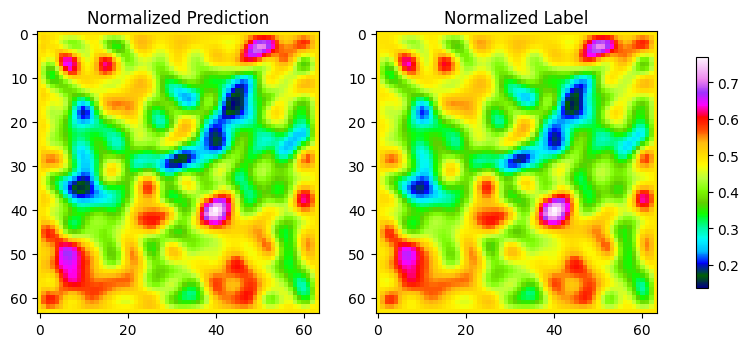

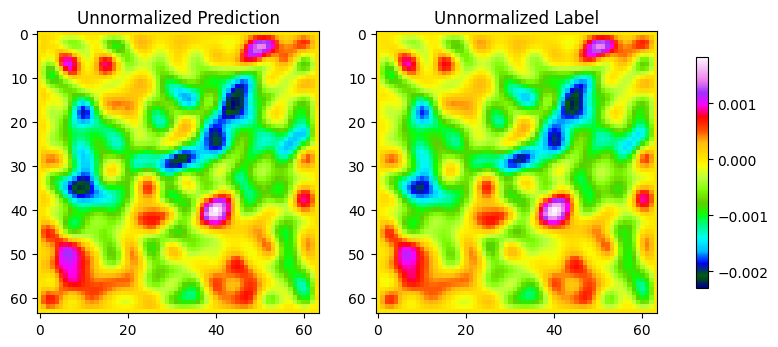

In [9]:
# plot normalized and unnormalized predictions and normalized and unnormalized labels for 1 sample
cmap = 'gist_ncar'

# get a sample from the dataset
sample_idx = 0
output_pred_sample = output_pred_batch[sample_idx].squeeze(0).cpu().numpy()
label_sample = label_batch[sample_idx].squeeze(0).cpu().numpy()

output_pred_sample_un = output_pred_unnorm[sample_idx].squeeze(0).cpu().numpy()
label_sample_un = label_unnorm[sample_idx].squeeze(0).cpu().numpy()
# Plot normalized predictions and labels with shared colorbar
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
vmin_norm = min(output_pred_sample.min(), label_sample.min())
vmax_norm = max(output_pred_sample.max(), label_sample.max())

im1 = axes[0].imshow(output_pred_sample, cmap=cmap, vmin=vmin_norm, vmax=vmax_norm)
axes[0].set_title("Normalized Prediction")
im2 = axes[1].imshow(label_sample, cmap=cmap, vmin=vmin_norm, vmax=vmax_norm)
axes[1].set_title("Normalized Label")

fig.colorbar(im1, ax=axes, shrink=0.6)
plt.show()

# Plot unnormalized predictions and labels with shared colorbar
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
vmin_unnorm = min(output_pred_sample_un.min(), label_sample_un.min())
vmax_unnorm = max(output_pred_sample_un.max(), label_sample_un.max())

im1 = axes[0].imshow(output_pred_sample_un, cmap=cmap, vmin=vmin_unnorm, vmax=vmax_unnorm)
axes[0].set_title("Unnormalized Prediction")
im2 = axes[1].imshow(label_sample_un, cmap=cmap, vmin=vmin_unnorm, vmax=vmax_unnorm)
axes[1].set_title("Unnormalized Label")

fig.colorbar(im1, ax=axes, shrink=0.6)
plt.show()


## 5. Replicating the Training Loop's Loss Calculation

Now we get a single batch of data, pass it through the model, and calculate the loss, just as it happens in the training loop of `TrainPINO_CNO.py`.

In [10]:
# Instantiate the loss function from the script
loss_pde_fn = Loss_PDE(which_example=which_example,
                         Normalization_values=Normalization_values,
                         p=training_properties['exp'],
                         pad_factor=training_properties['pad_factor'],
                         in_size=in_size)
print(loss_pde_fn)

Loss_PDE(
  (loss): Poisson_loss(
    (Laplace): Laplace()
    (loss): L1Loss()
  )
)


In [11]:
# Get a single batch from the train loader
input_batch_raw, label_batch_raw = next(iter(train_loader))

# Convert FNO format to CNO format if needed
if model_type == 'FNO':
    input_batch = convert_fno_to_cno_format(input_batch_raw)
    label_batch = convert_fno_to_cno_format(label_batch_raw)
    print(f"Converting batch for loss calculation:")
    print(f"  Raw input shape: {input_batch_raw.shape}")
    print(f"  Converted input shape: {input_batch.shape}")
else:
    input_batch = input_batch_raw
    label_batch = label_batch_raw

input_batch = input_batch.to(device)

# Get model prediction 
with torch.no_grad():
    if model_type == 'FNO':
        # Convert input to FNO format for the model
        model_input = convert_cno_to_fno_format(input_batch)
        model_output = model(model_input)
        # Convert output back to CNO format for loss calculation
        output_pred_batch = convert_fno_to_cno_format(model_output)
    else:
        # CNO model works directly with CNO format
        output_pred_batch = model(input_batch)

# Calculate loss as in the script
loss_PDE, loss_boundary = loss_pde_fn(input=input_batch, output=output_pred_batch)

print(f"Standard Calculation:")
print(f"  PDE Loss: {loss_PDE.item()}")
print(f"  Boundary Loss: {loss_boundary.item()}")

Standard Calculation:
  PDE Loss: 0.2990347743034363
  Boundary Loss: 3.54153016814962e-05


## 6. Debugging `Poisson_loss`

Here, we will manually perform the steps inside `Loss_PDE.forward` and `Poisson_loss.forward` to inspect the intermediate tensors. This is where you can add your debugging plots and checks.

Recall Poisson's Equation
$$\Delta u = -f$$
where $u$ is our searched for solution (label) and $f$ is our source functon (input).

In [12]:
print(input_batch.shape)
print(output_pred_batch.shape)

torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64])


In [13]:
# --- 1. Un-normalization (from Loss_PDE.forward) ---
# Note: input_batch and output_pred_batch are already in CNO format from previous cell
# but we need to ensure label_batch is also converted for consistency checking

unnormalize_fn = Unnormalize(which_example, Normalization_values)
input_un, output_pred_un = unnormalize_fn(input=input_batch, output=output_pred_batch)
print("Data un-normalized.")
print(input_un.shape)
print(output_pred_un.shape)

# --- 2. Inside Poisson_loss.forward ---
poisson_loss_fn = loss_pde_fn.loss # this is a Poisson_loss object (it has a loss method too)
input_un_sq = input_un.squeeze(1)
output_pred_un_sq = output_pred_un.squeeze(1)

# --- 3. Laplacian Calculation ---
laplace_fn = poisson_loss_fn.Laplace # this is a Laplace object
laplacian_of_output = laplace_fn(output_pred_un_sq)
print("Laplacian calculated.")

# --- 4. PDE Loss Calculation ---
print(f"Using {poisson_loss_fn.loss} loss function to calculate PDE loss")
loss_pde_manual = poisson_loss_fn.loss(-laplacian_of_output, input_un_sq)

# --- 5. Boundary Loss Calculation ---
# The original implementation only considers two boundaries
boundary_loss_x0 = poisson_loss_fn.loss(output_pred_un_sq[..., 0, :], torch.zeros_like(output_pred_un_sq[..., 0, :]))
boundary_loss_y0 = poisson_loss_fn.loss(output_pred_un_sq[..., :, 0], torch.zeros_like(output_pred_un_sq[..., :, 0]))
boundary_loss_manual = 0.5 * (boundary_loss_x0 + boundary_loss_y0)

print("\nManual Calculation:")
print(f"  PDE Loss: {loss_pde_manual.item()}")
print(f"  Boundary Loss: {boundary_loss_manual.item()}")

# --- 6. Verification ---
assert torch.allclose(loss_PDE, loss_pde_manual), "Manual PDE loss does not match"
assert torch.allclose(loss_boundary, boundary_loss_manual), "Manual boundary loss does not match"
print("\nVerification successful: Manual calculation matches the original function's output.")

Data un-normalized.
torch.Size([16, 1, 64, 64])
torch.Size([16, 1, 64, 64])
Laplacian calculated.
Using L1Loss() loss function to calculate PDE loss

Manual Calculation:
  PDE Loss: 0.2990347743034363
  Boundary Loss: 3.54153016814962e-05

Verification successful: Manual calculation matches the original function's output.


### Visualizing the results

Now you can plot the intermediate results for a single sample from the batch to see what's happening.

In [14]:
cmap = 'gist_ncar'

In [15]:
""" Intermediate Calculations """
# we have input_un_sq (f) and output_pred_un_sq (u*)
# we also want to calculate the laplacian of the actual labels (labels_un_sq) (u)

# --- 1. Un-normalization (from Loss_PDE.forward) ---
unnormalize_fn = Unnormalize(which_example, Normalization_values)
_, label_un = unnormalize_fn(input=input_batch, output=label_batch) #! just use the existing function
label_un_sq = label_un.squeeze(1)

# --- 2. Laplacian Calculation ---
laplacian_of_label = laplace_fn(label_un_sq) # laplacian of actual label (u) using our method
print("Laplacian of label calculated.")
print(f"Laplacian of label shape: {laplacian_of_label.shape}")

Laplacian of label calculated.
Laplacian of label shape: torch.Size([16, 64, 64])


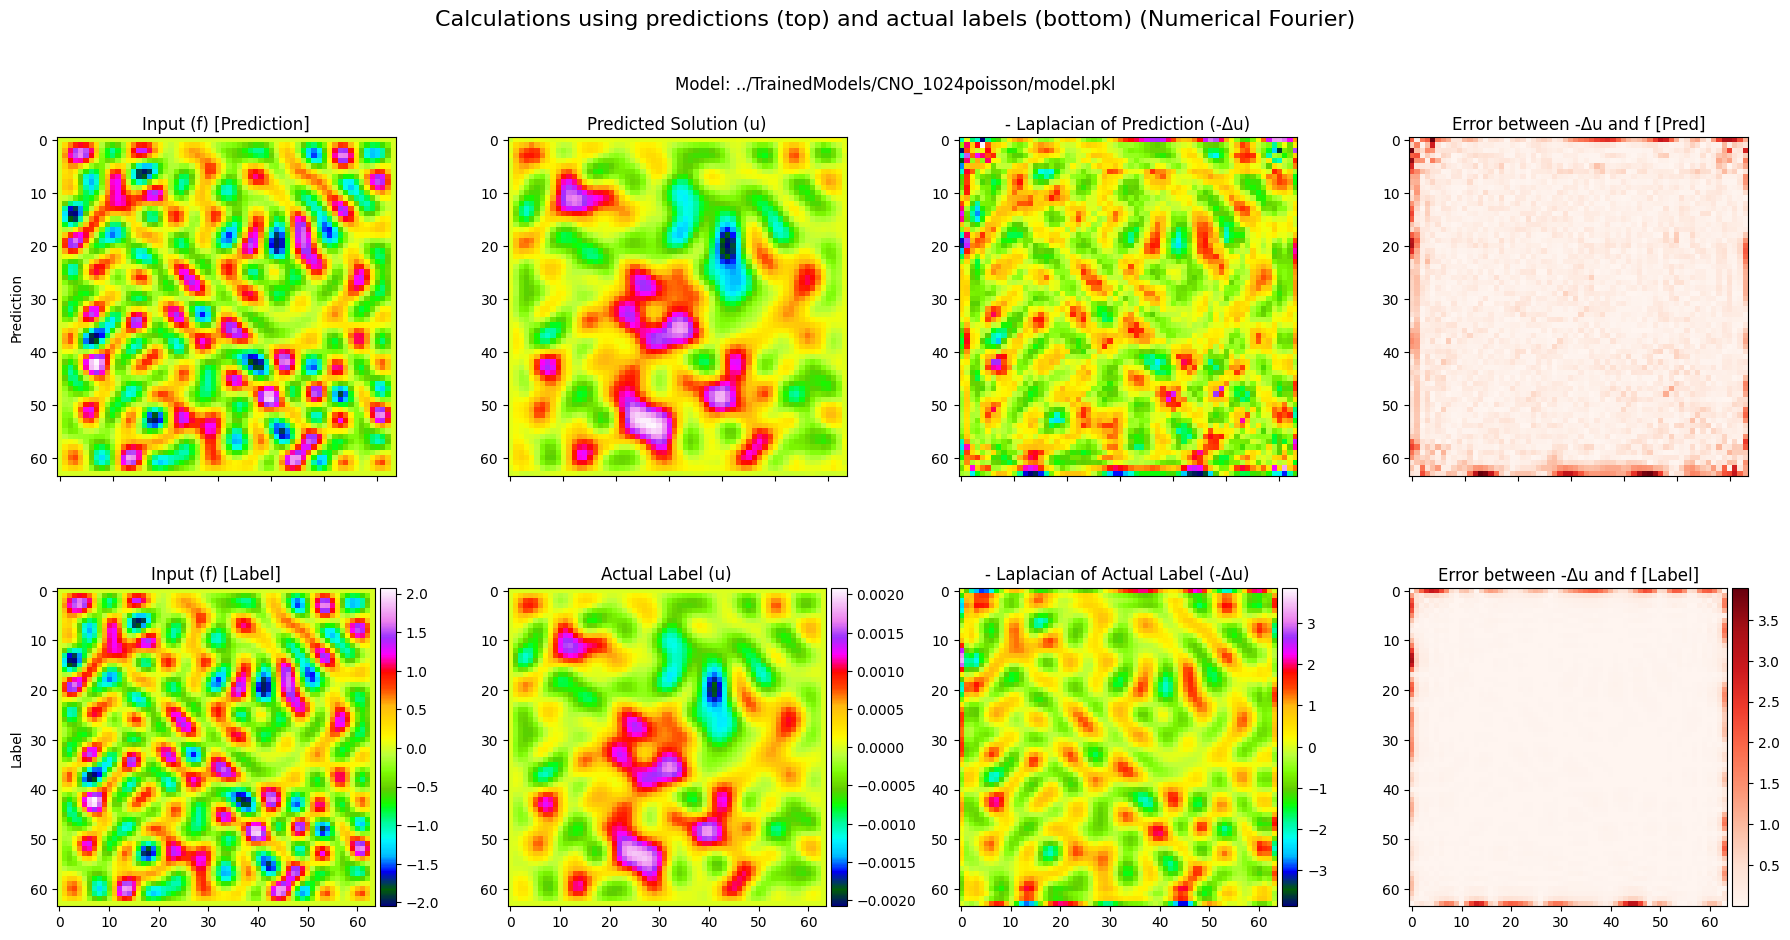

In [16]:
sample_idx = 0

""" Plot calculations using predictions and actual labels in a 2x4 grid with shared colorbars """

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle("Calculations using predictions (top) and actual labels (bottom) (Numerical Fourier)", fontsize=16)
# add secondary title with path to used model
fig.text(0.5, 0.90, f"Model: {pretrained_model_path}", ha='center', fontsize=12)

# --- Prepare data ---
# Row 0: predictions
input = input_un_sq[sample_idx].cpu().numpy()
pred_sol = output_pred_un_sq[sample_idx].cpu().numpy()
neg_lap_output = -laplacian_of_output[sample_idx].cpu().numpy()
error_output = np.abs(neg_lap_output - input)

# Row 1: labels
actual_label = label_un_sq[sample_idx].cpu().numpy()
neg_lap_label = -laplacian_of_label[sample_idx].cpu().numpy()
error_label = np.abs(neg_lap_label - input)

# --- Plotting ---
# For columns 0-2, use the same vmin/vmax for both rows for consistent colorbars
vmin0 = min(input.min(), input.min())
vmax0 = max(input.max(), input.max())

vmin1 = min(pred_sol.min(), actual_label.min())
vmax1 = max(pred_sol.max(), actual_label.max())

vmin2 = min(neg_lap_output.min(), neg_lap_label.min())
vmax2 = max(neg_lap_output.max(), neg_lap_label.max())

vmin3 = min(error_output.min(), error_label.min())
vmax3 = max(error_output.max(), error_label.max())

# Column 0: Input (f)
im00 = axes[0,0].imshow(input, cmap=cmap, vmin=vmin0, vmax=vmax0)
axes[0,0].set_title("Input (f) [Prediction]")
im10 = axes[1,0].imshow(input, cmap=cmap, vmin=vmin0, vmax=vmax0)
axes[1,0].set_title("Input (f) [Label]")

# Column 1: Solution (u)
im01 = axes[0,1].imshow(pred_sol, cmap=cmap, vmin=vmin1, vmax=vmax1)
axes[0,1].set_title("Predicted Solution (u)")
im11 = axes[1,1].imshow(actual_label, cmap=cmap, vmin=vmin1, vmax=vmax1)
axes[1,1].set_title("Actual Label (u)")

# Column 2: -Laplacian
im02 = axes[0,2].imshow(neg_lap_output, cmap=cmap, vmin=vmin2, vmax=vmax2)
axes[0,2].set_title("- Laplacian of Prediction (-Δu)")
im12 = axes[1,2].imshow(neg_lap_label, cmap=cmap, vmin=vmin2, vmax=vmax2)
axes[1,2].set_title("- Laplacian of Actual Label (-Δu)")

# Column 3: Error
im03 = axes[0,3].imshow(error_output, cmap='Reds', vmin=vmin3, vmax=vmax3)
axes[0,3].set_title("Error between -Δu and f [Pred]")
im13 = axes[1,3].imshow(error_label, cmap='Reds', vmin=vmin3, vmax=vmax3)
axes[1,3].set_title("Error between -Δu and f [Label]")

# --- Shared colorbars for each column ---
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_shared_colorbar(im_top, im_bottom, ax_top, ax_bottom, label=None):
    # Place colorbar to the right of the two axes
    divider = make_axes_locatable(ax_bottom)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im_bottom, cax=cax)
    if label:
        cb.set_label(label)
    # Remove ticklabels from top row for clarity
    ax_top.set_xticklabels([])
    ax_top.set_xlabel("")
    return cb

# For each column, add a single colorbar to the right of the bottom axis
add_shared_colorbar(im00, im10, axes[0,0], axes[1,0])
add_shared_colorbar(im01, im11, axes[0,1], axes[1,1])
add_shared_colorbar(im02, im12, axes[0,2], axes[1,2])
add_shared_colorbar(im03, im13, axes[0,3], axes[1,3])

# Set y-labels for rows
axes[0,0].set_ylabel("Prediction")
axes[1,0].set_ylabel("Label")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Some comments (for hybrid PI-model):
- Error between -laplace(u) and f for actual label is very significant: **The Fourier Numerical Differentiation is wrong**.
- The estimated -laplace(u) of the actual label is much smaller in magnitude than the input f (qualitative features are there, magnitude is off)
- As a consequence, the PI model (top row) prediction overcorrects and forces the prediction (u*) to be much bigger in magnitude

### **Use finite element methods to calculate the laplacian**

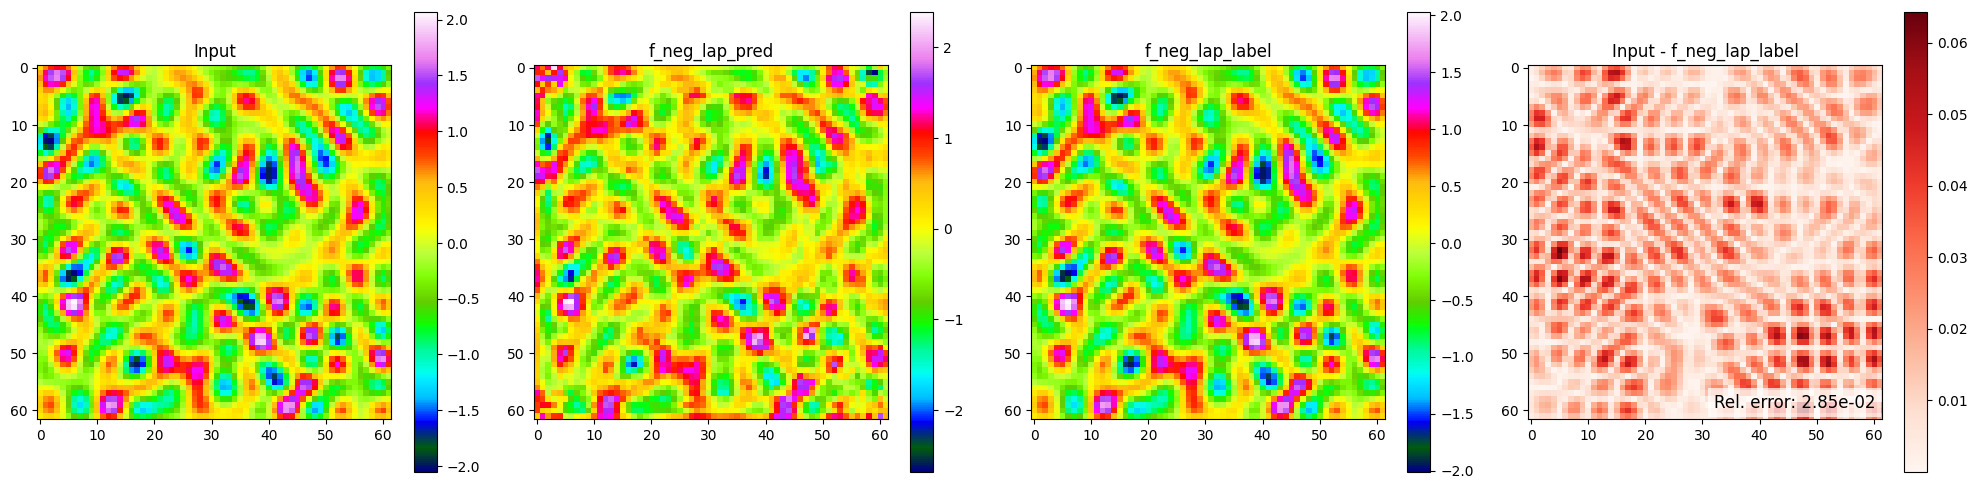

In [17]:
from FiniteDifferences import Laplace

# get our finite difference laplacian
laplace = Laplace(s=64, type="9-point")

# recall we have input (f), pred_sol (u*) and actual_label (u)
input = input_un_sq[sample_idx] # (64x64)
pred_sol = output_pred_un_sq[sample_idx].unsqueeze(0) # (1x64x64)
actual_label = label_un_sq[sample_idx].unsqueeze(0) # (1x64x64)

f_neg_lap_pred = -laplace(pred_sol)
f_neg_lap_label = -laplace(actual_label)

# convert shapes and types for plotting
input = input.cpu().numpy()
f_neg_lap_pred = f_neg_lap_pred.squeeze(0).cpu().numpy()
f_neg_lap_label = f_neg_lap_label.squeeze(0).cpu().numpy()


""" Plotting """
# Calculate the difference between input and f_neg_lap_label
# shrink the input by the cut_size
cut_size = 1
input = input[cut_size:-cut_size, cut_size:-cut_size]
diff_input_label = np.abs(input - f_neg_lap_label)

# Calculate relative error (L2 norm)
rel_error = np.linalg.norm(diff_input_label) / (np.linalg.norm(input) + 1e-12)

# plot input, f_neg_lap_pred, f_neg_lap_label, and their difference, with colorbars
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

im1 = axes[0].imshow(input, cmap='gist_ncar')
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('Input')

im2 = axes[1].imshow(f_neg_lap_pred, cmap='gist_ncar')
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('f_neg_lap_pred')

im3 = axes[2].imshow(f_neg_lap_label, cmap='gist_ncar')
fig.colorbar(im3, ax=axes[2])
axes[2].set_title('f_neg_lap_label')

im4 = axes[3].imshow(diff_input_label, cmap='Reds')
fig.colorbar(im4, ax=axes[3])
axes[3].set_title('Input - f_neg_lap_label')

# Add relative error tag in the top right corner of the error plot
axes[3].text(
    0.98, 0.02,
    f"Rel. error: {rel_error:.2e}",
    color='black',
    fontsize=12,
    ha='right',
    va='bottom',
    transform=axes[3].transAxes,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.tight_layout()
plt.show()

### **Comparison of Fourier vs Finite Difference Laplacian Methods**

Now let's compare the two Laplacian calculation methods side by side using the actual labels.


Fourier method relative error: 1.141935e-01
Finite difference method relative error: 2.852953e-02
Shape of input_f_cropped: (62, 62)
Shape of fourier result: (62, 62)
Shape of finite diff result: (62, 62)


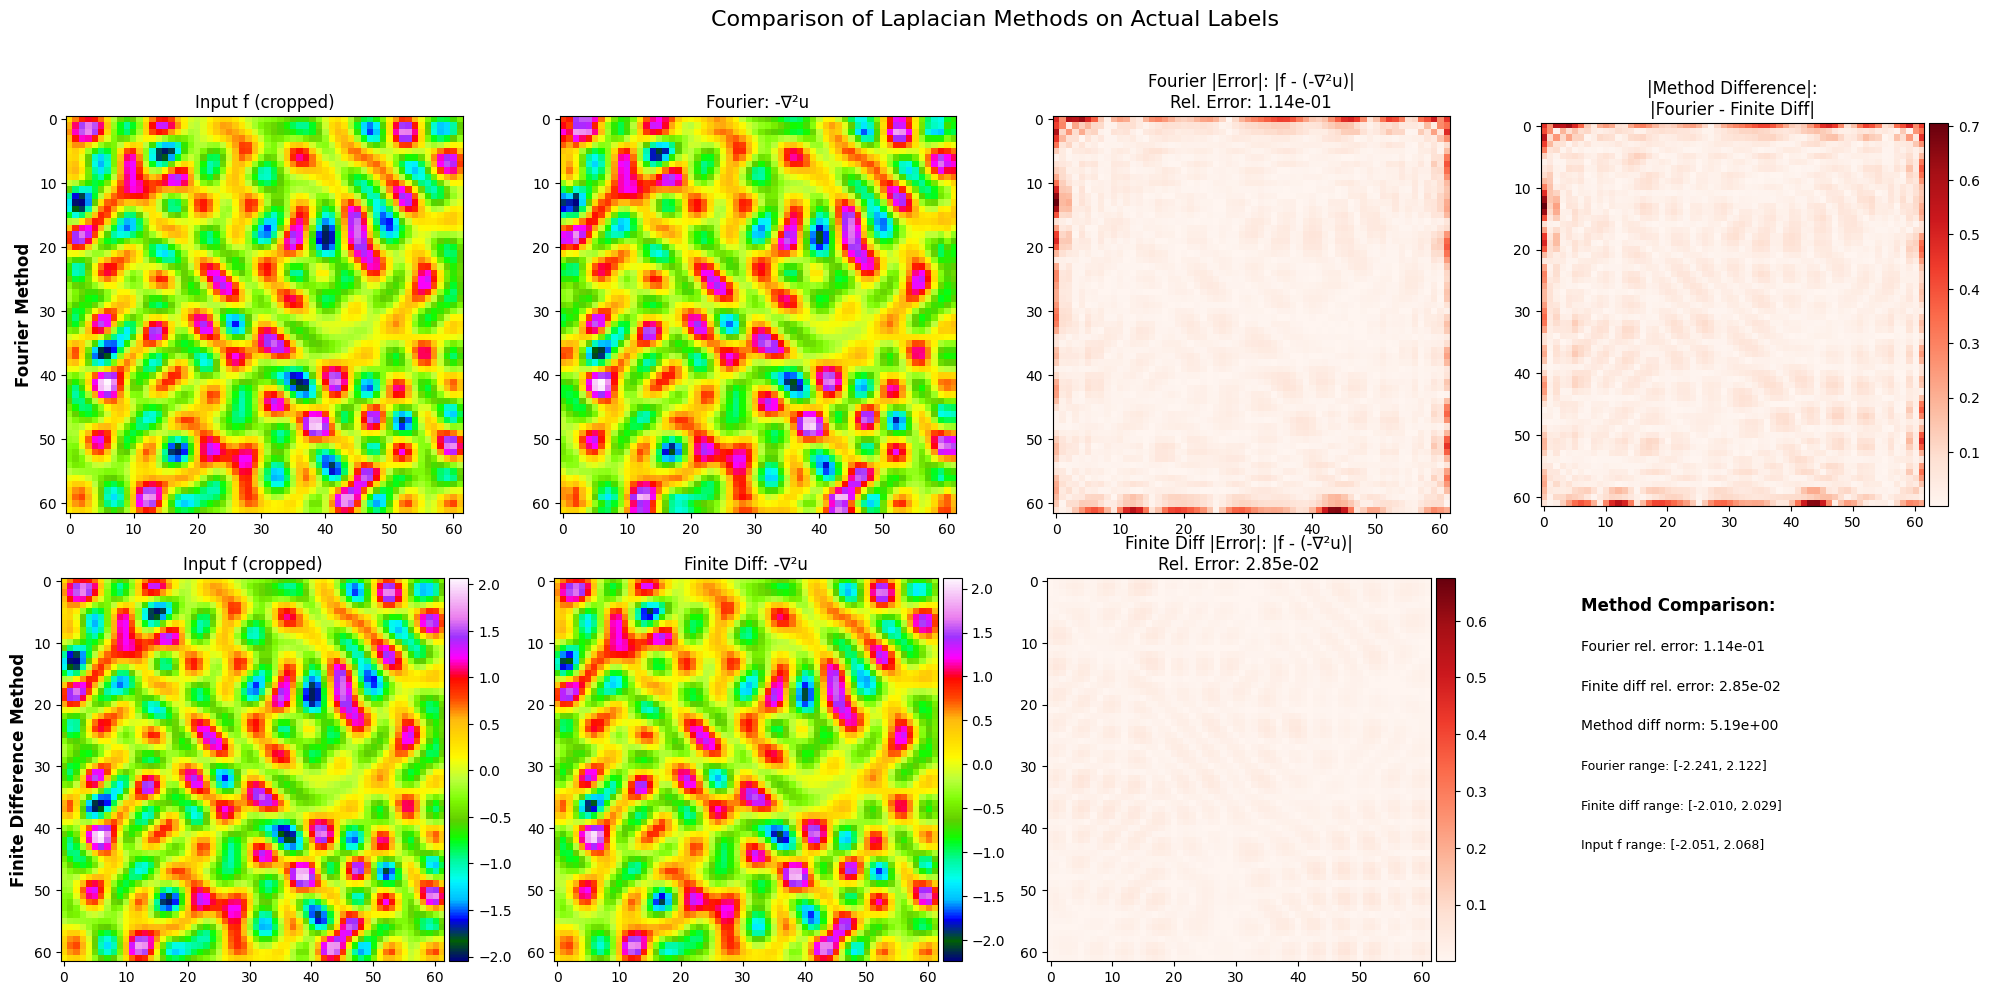

In [18]:
# --- Method 1: Fourier-based Laplacian (from Loss_PDE) ---
# This is already calculated above as laplacian_of_label
fourier_neg_laplacian = -laplacian_of_label[sample_idx].cpu().numpy()

# --- Method 2: Finite Difference Laplacian ---
# Use the finite difference implementation we defined above
fd_laplace = Laplace(s=64, type="9-point")
actual_label_unsqueezed = label_un_sq[sample_idx].unsqueeze(0)  # Add batch dimension for conv2d
fd_neg_laplacian = -fd_laplace(actual_label_unsqueezed).squeeze(0).cpu().numpy()

# --- Prepare data for comparison ---
# The input f (this should match both negative laplacians if they're correct)
input_f = input_un_sq[sample_idx].cpu().numpy()

# For finite difference method, we need to account for the fact that conv2d reduces the size
# So we crop the input to match
if fd_neg_laplacian.shape != input_f.shape:
    crop_size = (input_f.shape[0] - fd_neg_laplacian.shape[0]) // 2
    input_f_cropped = input_f[crop_size:-crop_size, crop_size:-crop_size]
else:
    input_f_cropped = input_f
    crop_size = 0

# Also crop the Fourier result to match
if crop_size > 0:
    fourier_neg_laplacian_cropped = fourier_neg_laplacian[crop_size:-crop_size, crop_size:-crop_size]
else:
    fourier_neg_laplacian_cropped = fourier_neg_laplacian

# Calculate errors (absolute values)
error_fourier = np.abs(fourier_neg_laplacian_cropped - input_f_cropped)
error_fd = np.abs(fd_neg_laplacian - input_f_cropped)

# Calculate relative errors
rel_error_fourier = np.linalg.norm(fourier_neg_laplacian_cropped - input_f_cropped) / (np.linalg.norm(input_f_cropped) + 1e-12)
rel_error_fd = np.linalg.norm(fd_neg_laplacian - input_f_cropped) / (np.linalg.norm(input_f_cropped) + 1e-12)

print(f"Fourier method relative error: {rel_error_fourier:.6e}")
print(f"Finite difference method relative error: {rel_error_fd:.6e}")
print(f"Shape of input_f_cropped: {input_f_cropped.shape}")
print(f"Shape of fourier result: {fourier_neg_laplacian_cropped.shape}")
print(f"Shape of finite diff result: {fd_neg_laplacian.shape}")

"""-----------------------Plotting------------------------"""
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Comparison of Laplacian Methods on Actual Labels", fontsize=16)

# Determine consistent color scales for better comparison
vmin_laplacian = min(fourier_neg_laplacian_cropped.min(), fd_neg_laplacian.min())
vmax_laplacian = max(fourier_neg_laplacian_cropped.max(), fd_neg_laplacian.max())

vmin_error = min(error_fourier.min(), error_fd.min())
vmax_error = max(error_fourier.max(), error_fd.max())

# Row 1: Fourier method
axes[0,0].imshow(input_f_cropped, cmap='gist_ncar')
axes[0,0].set_title('Input f (cropped)')
im01 = axes[0,1].imshow(fourier_neg_laplacian_cropped, cmap='gist_ncar', vmin=vmin_laplacian, vmax=vmax_laplacian)
axes[0,1].set_title('Fourier: -∇²u')
im02 = axes[0,2].imshow(error_fourier, cmap='Reds', vmin=vmin_error, vmax=vmax_error)
axes[0,2].set_title(f'Fourier |Error|: |f - (-∇²u)|\nRel. Error: {rel_error_fourier:.2e}')
# Difference between methods
method_diff = np.abs(fourier_neg_laplacian_cropped - fd_neg_laplacian)
im03 = axes[0,3].imshow(method_diff, cmap='Reds')
axes[0,3].set_title('|Method Difference|:\n|Fourier - Finite Diff|')

# Row 2: Finite difference method  
axes[1,0].imshow(input_f_cropped, cmap='gist_ncar')
axes[1,0].set_title('Input f (cropped)')
im11 = axes[1,1].imshow(fd_neg_laplacian, cmap='gist_ncar', vmin=vmin_laplacian, vmax=vmax_laplacian)
axes[1,1].set_title('Finite Diff: -∇²u')
im12 = axes[1,2].imshow(error_fd, cmap='Reds', vmin=vmin_error, vmax=vmax_error)
axes[1,2].set_title(f'Finite Diff |Error|: |f - (-∇²u)|\nRel. Error: {rel_error_fd:.2e}')
# Statistics comparison
axes[1,3].text(0.1, 0.9, 'Method Comparison:', transform=axes[1,3].transAxes, fontsize=12, weight='bold')
axes[1,3].text(0.1, 0.8, f'Fourier rel. error: {rel_error_fourier:.2e}', transform=axes[1,3].transAxes, fontsize=10)
axes[1,3].text(0.1, 0.7, f'Finite diff rel. error: {rel_error_fd:.2e}', transform=axes[1,3].transAxes, fontsize=10)
axes[1,3].text(0.1, 0.6, f'Method diff norm: {np.linalg.norm(method_diff):.2e}', transform=axes[1,3].transAxes, fontsize=10)
axes[1,3].text(0.1, 0.5, f'Fourier range: [{fourier_neg_laplacian_cropped.min():.3f}, {fourier_neg_laplacian_cropped.max():.3f}]', transform=axes[1,3].transAxes, fontsize=9)
axes[1,3].text(0.1, 0.4, f'Finite diff range: [{fd_neg_laplacian.min():.3f}, {fd_neg_laplacian.max():.3f}]', transform=axes[1,3].transAxes, fontsize=9)
axes[1,3].text(0.1, 0.3, f'Input f range: [{input_f_cropped.min():.3f}, {input_f_cropped.max():.3f}]', transform=axes[1,3].transAxes, fontsize=9)
axes[1,3].set_xlim(0, 1)
axes[1,3].set_ylim(0, 1)
axes[1,3].axis('off')

# Add colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Colorbar for input (first column)
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(axes[0,0].images[0], cax=cax)

# Colorbar for laplacian results (second column)
divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im11, cax=cax)

# Colorbar for errors (third column)
divider = make_axes_locatable(axes[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im12, cax=cax)

# Colorbar for method difference (fourth column)
divider = make_axes_locatable(axes[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im03, cax=cax)

# Set row labels
axes[0,0].set_ylabel("Fourier Method", fontsize=12, weight='bold')
axes[1,0].set_ylabel("Finite Difference Method", fontsize=12, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### **Compare Fourier and Finite Methods on Dummy Data**

Unfinished

Generated dummy input batch shape: torch.Size([3, 64, 64])
Dummy input range: [0.000, 3.673]


Original shapes - Input: 64, Fourier: 64, Finite Diff: 62
After cropping - Input: (3, 62, 62), Fourier: (3, 62, 62), Finite Diff: (3, 62, 62)
Cropped input shape: (3, 62, 62)
Fourier laplacian shape: (3, 62, 62)
Finite diff laplacian shape: (3, 62, 62)


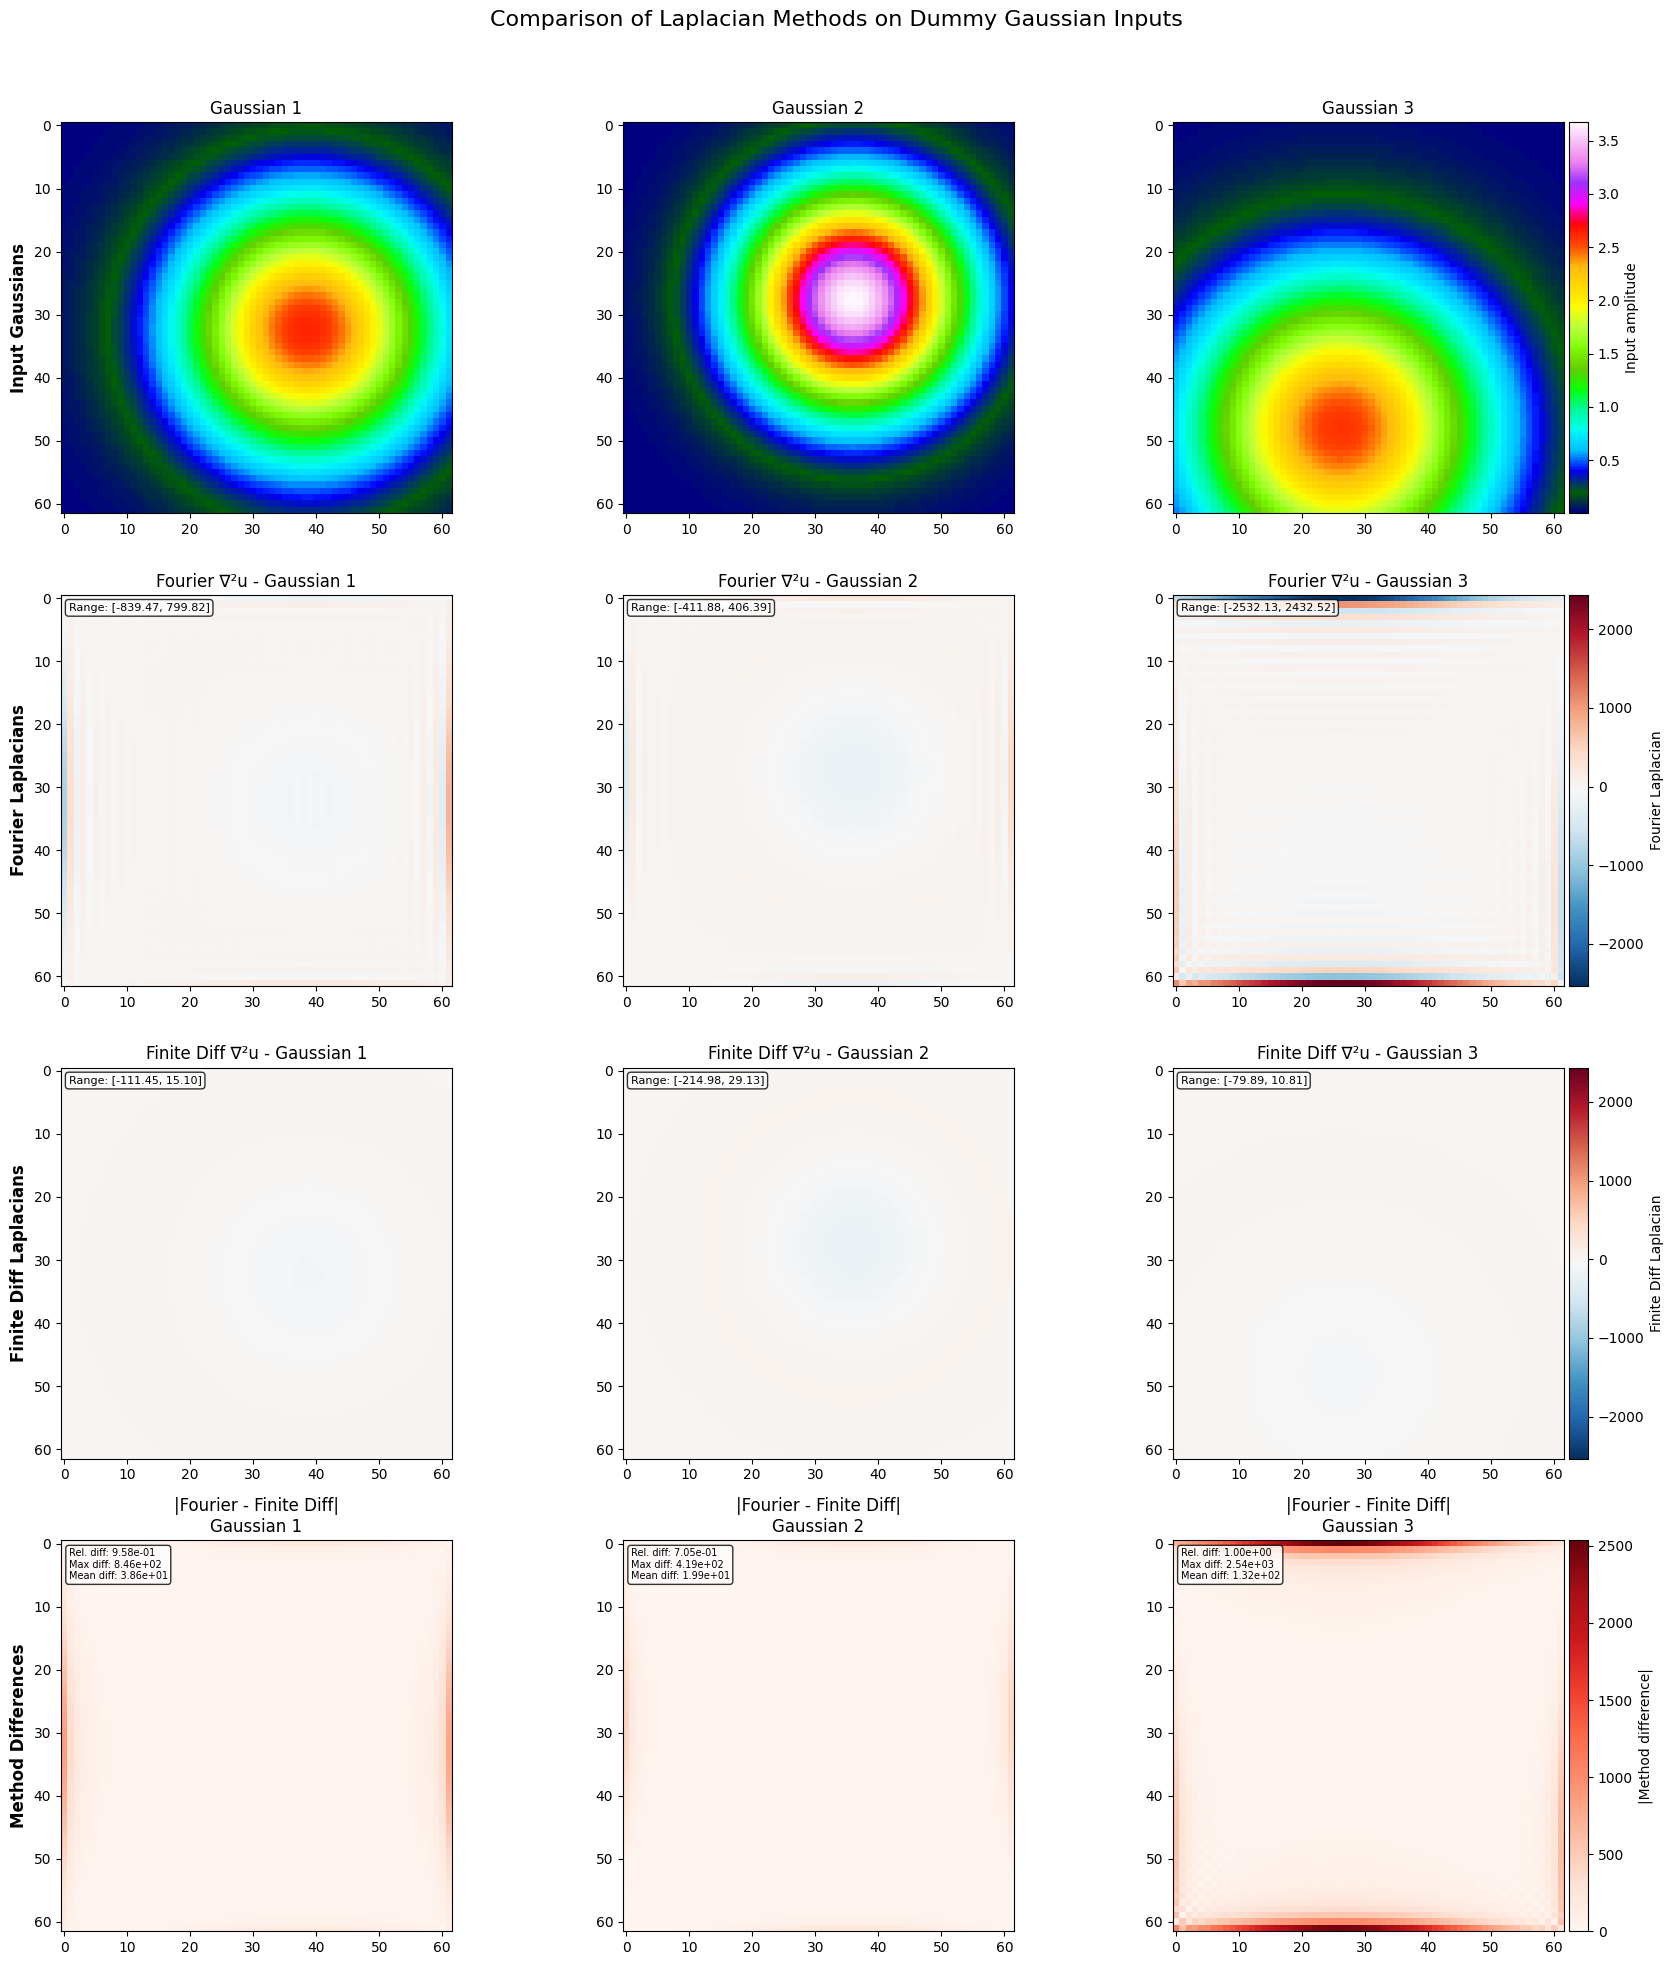


Summary Statistics:
Gaussian 1:
  Input range: [0.004, 2.633]
  Fourier Laplacian range: [-839.472, 799.824]
  Finite Diff Laplacian range: [-111.452, 15.104]
  Relative method difference: 9.579600e-01
  Max absolute difference: 8.461852e+02

Gaussian 2:
  Input range: [0.001, 3.673]
  Fourier Laplacian range: [-411.879, 406.391]
  Finite Diff Laplacian range: [-214.984, 29.129]
  Relative method difference: 7.049718e-01
  Max absolute difference: 4.194344e+02

Gaussian 3:
  Input range: [0.003, 2.587]
  Fourier Laplacian range: [-2532.133, 2432.523]
  Finite Diff Laplacian range: [-79.890, 10.813]
  Relative method difference: 1.000661e+00
  Max absolute difference: 2.535585e+03



In [19]:
# Generate dummy input data - 3 random Gaussians for comparing Laplacian methods
# Fixed: Changed batch_size from 1 to 3 to match the plotting code expectations
import numpy as np
import torch

# Parameters for Gaussian generation
batch_size = 3  # Generate 3 examples to match the plotting code
grid_size = 64
domain_size = 1.0  # Domain is [0, 1] x [0, 1]

# Create coordinate grids
x = torch.linspace(0, domain_size, grid_size)
y = torch.linspace(0, domain_size, grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Generate 3 different Gaussian functions
dummy_inputs = []
for i in range(batch_size):
    # Random centers (keep within domain boundaries)
    cx = np.random.uniform(0.2, 0.8)  # Keep away from boundaries
    cy = np.random.uniform(0.2, 0.8)
    
    # Random width (standard deviation)
    sigma = np.random.uniform(0.1, 0.3)
    
    # Random amplitude - positive only for clearer visualization
    amplitude = np.random.uniform(1, 4)
    
    # Generate Gaussian
    gaussian = amplitude * torch.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))
    dummy_inputs.append(gaussian)

dummy_inputs = torch.stack(dummy_inputs)
print(f"Generated dummy input batch shape: {dummy_inputs.shape}")
print(f"Dummy input range: [{dummy_inputs.min():.3f}, {dummy_inputs.max():.3f}]")

# Calculate Laplacians using both methods
# --- Method 1: Fourier-based Laplacian (from ModulePDELoss) ---
from Physics_NO.loss_functions.ModulePDELoss import Laplace as FourierLaplace

# --- Method 2: Finite Difference Laplacian (defined in notebook) ---
# Use the finite difference Laplace class defined earlier in the notebook

fourier_laplacians = []
fd_laplacians = []

for i in range(batch_size):
    # Fourier method (using the imported Laplace class)
    fourier_laplace = FourierLaplace(s=grid_size, D=domain_size)
    dummy_input_unsqueezed = dummy_inputs[i].unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    fourier_lap = fourier_laplace(dummy_input_unsqueezed)
    fourier_laplacians.append(fourier_lap.squeeze(0).squeeze(0))
    
    # Finite difference method (using the 9-point stencil)
    fd_laplace = Laplace(s=grid_size, type="9-point")
    fd_lap = fd_laplace(dummy_input_unsqueezed)
    fd_laplacians.append(fd_lap.squeeze(0).squeeze(0))

fourier_laplacians = torch.stack(fourier_laplacians)
fd_laplacians = torch.stack(fd_laplacians)

# Convert to numpy for plotting
dummy_inputs_np = dummy_inputs.cpu().numpy()
fourier_laplacians_np = fourier_laplacians.cpu().numpy()
fd_laplacians_np = fd_laplacians.cpu().numpy()

# Handle size differences due to finite difference boundary effects
# Both methods should handle the cropping to ensure same dimensions
fourier_shape = fourier_laplacians_np.shape[-1]
fd_shape = fd_laplacians_np.shape[-1]
input_shape = dummy_inputs_np.shape[-1]

print(f"Original shapes - Input: {input_shape}, Fourier: {fourier_shape}, Finite Diff: {fd_shape}")

# Determine the target size as the minimum of all three
target_size = min(input_shape, fourier_shape, fd_shape)

# Calculate cropping for each array
input_crop = (input_shape - target_size) // 2
fourier_crop = (fourier_shape - target_size) // 2
fd_crop = (fd_shape - target_size) // 2

# Apply cropping to all arrays to ensure same size
if input_crop > 0:
    dummy_inputs_cropped = dummy_inputs_np[:, input_crop:-input_crop, input_crop:-input_crop]
else:
    dummy_inputs_cropped = dummy_inputs_np

if fourier_crop > 0:
    fourier_laplacians_cropped = fourier_laplacians_np[:, fourier_crop:-fourier_crop, fourier_crop:-fourier_crop]
else:
    fourier_laplacians_cropped = fourier_laplacians_np

if fd_crop > 0:
    fd_laplacians_cropped = fd_laplacians_np[:, fd_crop:-fd_crop, fd_crop:-fd_crop]
else:
    fd_laplacians_cropped = fd_laplacians_np

# Verify all arrays now have the same shape
print(f"After cropping - Input: {dummy_inputs_cropped.shape}, Fourier: {fourier_laplacians_cropped.shape}, Finite Diff: {fd_laplacians_cropped.shape}")

# Calculate differences between methods
method_differences = np.abs(fourier_laplacians_cropped - fd_laplacians_cropped)

print(f"Cropped input shape: {dummy_inputs_cropped.shape}")
print(f"Fourier laplacian shape: {fourier_laplacians_cropped.shape}")
print(f"Finite diff laplacian shape: {fd_laplacians_cropped.shape}")

# Plot comparison with 4 rows: Input, Fourier Laplacian, Finite Diff Laplacian, Method Difference
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle("Comparison of Laplacian Methods on Dummy Gaussian Inputs", fontsize=16)

# Determine consistent color scales
vmin_input = dummy_inputs_cropped.min()
vmax_input = dummy_inputs_cropped.max()
vmin_laplacian = min(fourier_laplacians_cropped.min(), fd_laplacians_cropped.min())
vmax_laplacian = max(fourier_laplacians_cropped.max(), fd_laplacians_cropped.max())
vmin_diff = 0  # Set minimum to 0 for error visualization
vmax_diff = method_differences.max()

# Row 1: Input Gaussians
for i in range(3):
    if i == 0:
        axes[0,i].set_ylabel("Input Gaussians", fontsize=12, weight='bold')
    
    im0 = axes[0,i].imshow(dummy_inputs_cropped[i], cmap='gist_ncar', vmin=vmin_input, vmax=vmax_input)
    axes[0,i].set_title(f'Gaussian {i+1}')

# Row 2: Fourier Laplacians
for i in range(3):
    if i == 0:
        axes[1,i].set_ylabel("Fourier Laplacians", fontsize=12, weight='bold')
    
    im1 = axes[1,i].imshow(fourier_laplacians_cropped[i], cmap='RdBu_r', vmin=vmin_laplacian, vmax=vmax_laplacian)
    axes[1,i].set_title(f'Fourier ∇²u - Gaussian {i+1}')
    
    # Add statistics text
    fourier_range = f'[{fourier_laplacians_cropped[i].min():.2f}, {fourier_laplacians_cropped[i].max():.2f}]'
    axes[1,i].text(0.02, 0.98, f'Range: {fourier_range}', 
                   transform=axes[1,i].transAxes, fontsize=8, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')

# Row 3: Finite Difference Laplacians  
for i in range(3):
    if i == 0:
        axes[2,i].set_ylabel("Finite Diff Laplacians", fontsize=12, weight='bold')
    
    im2 = axes[2,i].imshow(fd_laplacians_cropped[i], cmap='RdBu_r', vmin=vmin_laplacian, vmax=vmax_laplacian)
    axes[2,i].set_title(f'Finite Diff ∇²u - Gaussian {i+1}')
    
    # Add statistics text
    fd_range = f'[{fd_laplacians_cropped[i].min():.2f}, {fd_laplacians_cropped[i].max():.2f}]'
    axes[2,i].text(0.02, 0.98, f'Range: {fd_range}', 
                   transform=axes[2,i].transAxes, fontsize=8, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')

# Row 4: Method Differences
for i in range(3):
    if i == 0:
        axes[3,i].set_ylabel("Method Differences", fontsize=12, weight='bold')
    
    # Show method difference with colorbar from 0 to max
    im3 = axes[3,i].imshow(method_differences[i], cmap='Reds', vmin=vmin_diff, vmax=vmax_diff)
    axes[3,i].set_title(f'|Fourier - Finite Diff|\nGaussian {i+1}')
    
    # Add comprehensive statistics
    rel_diff = np.linalg.norm(method_differences[i]) / (np.linalg.norm(fourier_laplacians_cropped[i]) + 1e-12)
    max_diff = method_differences[i].max()
    mean_diff = method_differences[i].mean()
    
    axes[3,i].text(0.02, 0.98, f'Rel. diff: {rel_diff:.2e}\nMax diff: {max_diff:.2e}\nMean diff: {mean_diff:.2e}', 
                   transform=axes[3,i].transAxes, fontsize=7, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')

# Add colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Colorbar for inputs (row 1)
divider = make_axes_locatable(axes[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax, label='Input amplitude')

# Colorbar for Fourier Laplacians (row 2)  
divider = make_axes_locatable(axes[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax, label='Fourier Laplacian')

# Colorbar for Finite Diff Laplacians (row 3)
divider = make_axes_locatable(axes[2,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax, label='Finite Diff Laplacian')

# Colorbar for differences (row 4) - from 0 to max
divider = make_axes_locatable(axes[3,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax, label='|Method difference|')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for i in range(batch_size):
    rel_diff = np.linalg.norm(method_differences[i]) / (np.linalg.norm(fourier_laplacians_cropped[i]) + 1e-12)
    print(f"Gaussian {i+1}:")
    print(f"  Input range: [{dummy_inputs_cropped[i].min():.3f}, {dummy_inputs_cropped[i].max():.3f}]")
    print(f"  Fourier Laplacian range: [{fourier_laplacians_cropped[i].min():.3f}, {fourier_laplacians_cropped[i].max():.3f}]")
    print(f"  Finite Diff Laplacian range: [{fd_laplacians_cropped[i].min():.3f}, {fd_laplacians_cropped[i].max():.3f}]")
    print(f"  Relative method difference: {rel_diff:.6e}")
    print(f"  Max absolute difference: {method_differences[i].max():.6e}")
    print()
